In [1]:
import sys
import os

package_path: str = '..'
if package_path not in sys.path:
    sys.path.append(package_path)

In [2]:
%reload_ext autoreload
%autoreload 2

In [7]:
from src.analyzer.loader import NpzLoader
from src.utils.file_util import get_run_scan_directory
from src.config.config import load_config, ExpConfig


config: ExpConfig = load_config()
config.path

ExpPaths(load_dir='D:/dev/xfel_sample_data', analysis_dir='D:/dev/xfel_sample_data', param_dir='D:/dev/xfel_sample_data\\DataParameter', image_dir='D:/dev/xfel_sample_data\\Image', mat_dir='D:/dev/xfel_sample_data\\Mat_files', npz_dir='D:/dev/xfel_sample_data\\Npz_files', tif_dir='D:/dev/xfel_sample_data\\Tif_files')

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.typing as npt
from roi_rectangle import RoiRectangle

In [18]:
npz_dir: str = config.path.npz_dir
run_n: int = 62
npz_file: str = os.path.join(get_run_scan_directory(npz_dir, run_n, 1), f"run={run_n:0>3}, scan=001.npz")

_data: dict[str: npt.NDArray] = NpzLoader(npz_file).data
delays: npt.NDArray = _data["delay"]
pons: npt.NDArray = _data["pon"]
poffs: npt.NDArray = _data["poff"]

print(f"{delays.shape = }")
print(f"{pons.shape = }")
print(f"{poffs.shape = }")

delays.shape = (117,)
pons.shape = (117, 514, 1030)
poffs.shape = (117, 514, 1030)


RoiRectangle(x1=360, y1=80, x2=440, y2=150)

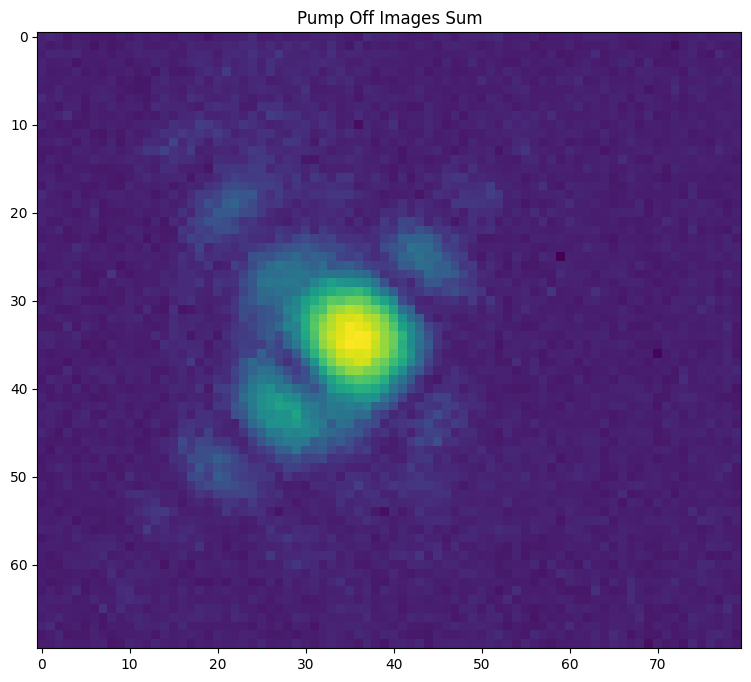

In [65]:
roi_rect: RoiRectangle = RoiRectangle(360, 80, 440, 150)
roi_poffs: npt.NDArray = roi_rect.slice(poffs)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.imshow(np.log1p(roi_poffs[0]))
ax.set_title("Pump Off Images Sum")

roi_rect

In [100]:
img: npt.NDArray = roi_poffs[0]

img2: npt.NDArray = img.reshape(-1, 1)
print(img2)
img2.shape

[[0.39321804]
 [0.50523925]
 [0.40716764]
 ...
 [0.32599974]
 [0.3967205 ]
 [0.32355526]]


(5600, 1)

In [227]:
from sklearn.mixture import GaussianMixture as GMM

gmm_model = GMM(n_components=4, covariance_type='full').fit(img2)
gmm_labels: npt.NDArray[np.int64] = gmm_model.predict(img2)
print(f"{gmm_labels.shape = }")
# gmm_labels.shape = (5600,)

original_shape: tuple[int, int] = img.shape
segmented: npt.NDArray[np.int64] = gmm_labels.reshape(original_shape[0], original_shape[1])
print(f"{segmented.shape = }")
# segmented.shape = (70, 80)
weights, means, covars = gmm_model.weights_, gmm_model.means_, gmm_model.covariances_

print(f"{weights.shape = }")
print(f"{means.shape = }")
print(f"{covars.shape = }")
# weights.shape = (4,)
# means.shape = (4, 1)
# covars.shape = (4, 1, 1)

gmm_labels.shape = (5600,)
segmented.shape = (70, 80)
weights.shape = (4,)
means.shape = (4, 1)
covars.shape = (4, 1, 1)


Text(0.5, 1.0, 'Pump Off segmented')

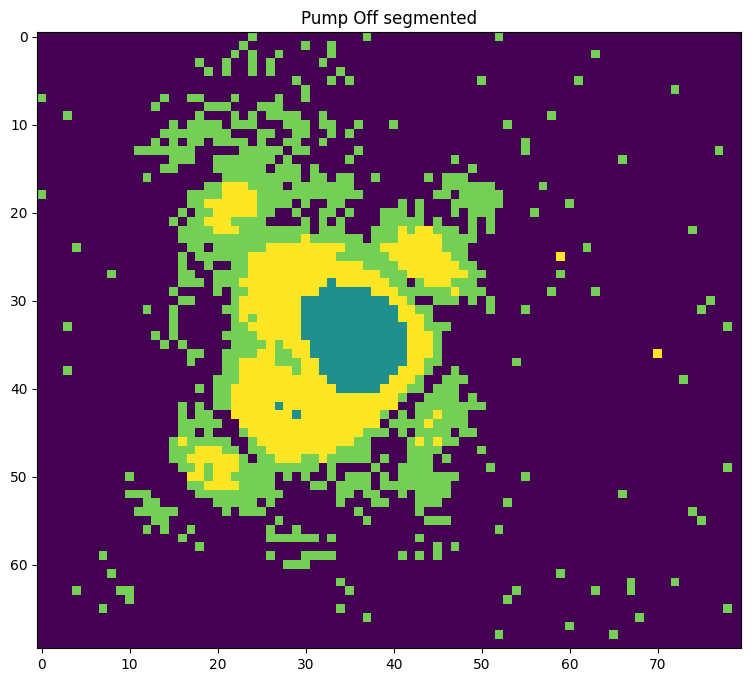

In [226]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.imshow(np.log1p(segmented))
ax.set_title("Pump Off segmented")

In [250]:
image = np.maximum(roi_poffs[0], 1)

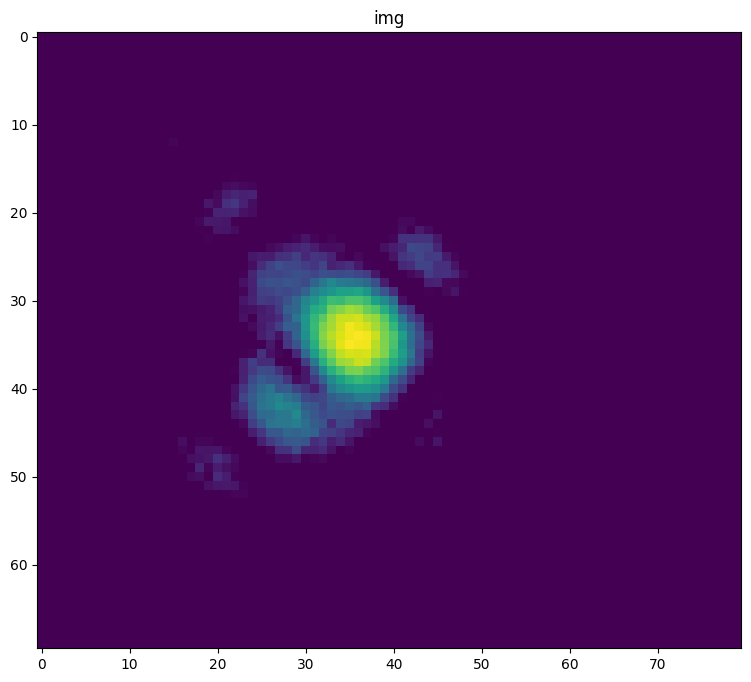

In [251]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.imshow(np.log1p(image))
ax.set_title("img");

In [252]:
x, y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
coordinates = np.column_stack([x.ravel(), y.ravel()])
pixel_values = image.ravel()

# 좌표와 픽셀 값을 결합한 데이터 생성 (x, y, pixel_value)
data = np.column_stack([coordinates, pixel_values])
# Gaussian Mixture Model (GMM) 적용
gmm = GMM(n_components=10, covariance_type='full')
gmm.fit(data)

GaussianMixture(n_components=10)

gmm_labels.shape = (5600,)


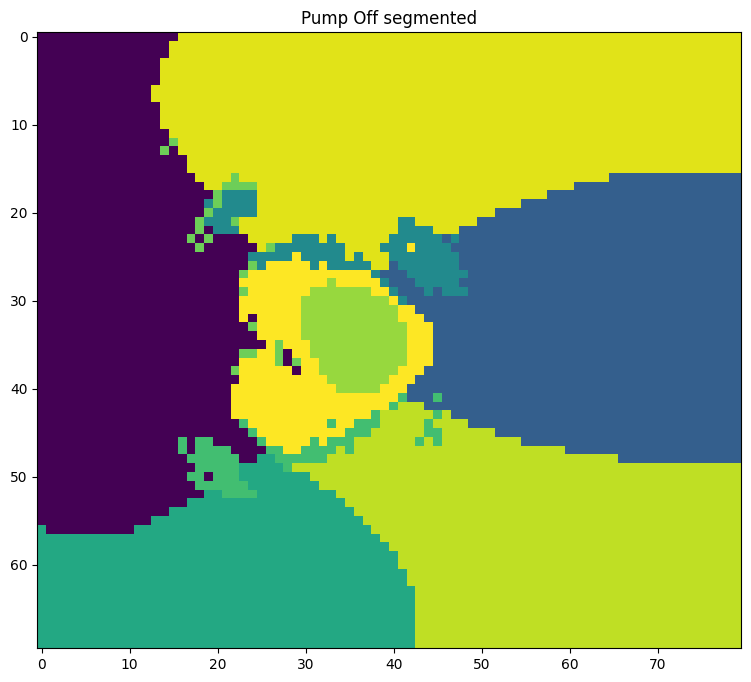

In [253]:
gmm_labels: npt.NDArray[np.int64] = gmm.predict(data)
print(f"{gmm_labels.shape = }")

original_shape: tuple[int, int] = image.shape
segmented: npt.NDArray[np.int64] = gmm_labels.reshape(original_shape[0], original_shape[1])

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.imshow(np.log1p(segmented))
ax.set_title("Pump Off segmented");

C:\Users\isaac\AppData\Local\Temp\ipykernel_22268\2533714338.py:17: RuntimeWarning: invalid value encountered in log1p
  plt.imshow(np.log1p(generated_image), cmap='viridis')


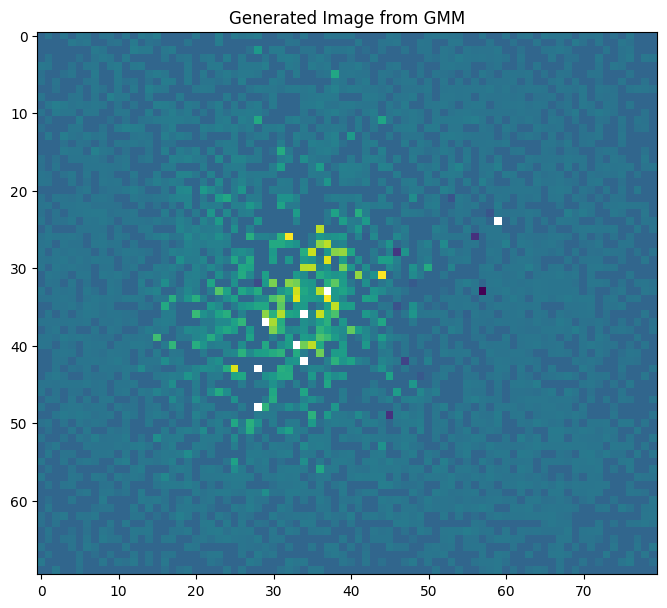

In [243]:
# GMM으로부터 새로운 데이터 생성
generated_data, _ = gmm.sample(n_samples=img.size)

# 생성된 데이터에서 좌표와 픽셀 값 분리
generated_coordinates = generated_data[:, :2].astype(int)
generated_pixel_values = generated_data[:, 2]

# 생성된 이미지를 원본과 동일한 크기로 복원
generated_image = np.zeros_like(img)
for coord, pixel_value in zip(generated_coordinates, generated_pixel_values):
    x, y = coord
    if 0 <= x < generated_image.shape[1] and 0 <= y < generated_image.shape[0]:
        generated_image[y, x] = pixel_value

# 생성된 이미지 시각화
plt.figure(figsize=(8, 8))
plt.imshow(np.log1p(generated_image), cmap='viridis')
plt.title("Generated Image from GMM");

In [260]:
log_img = np.log1p(img)

x, y = np.meshgrid(np.arange(img.shape[1]), np.arange(img.shape[0]))
data = np.stack([x.ravel(), y.ravel(), img.ravel()], axis=1)

gmm_model = GMM(n_components=5, covariance_type='full').fit(data)
gmm_labels: npt.NDArray[np.int64] = gmm_model.predict(data)
segmented = gmm_labels.reshape(*img.shape)
segmented

array([[0, 3, 0, ..., 3, 3, 3],
       [0, 0, 0, ..., 3, 3, 3],
       [0, 0, 0, ..., 3, 3, 3],
       ...,
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2]], dtype=int64)

Text(0.5, 1.0, 'Pump Off segmented')

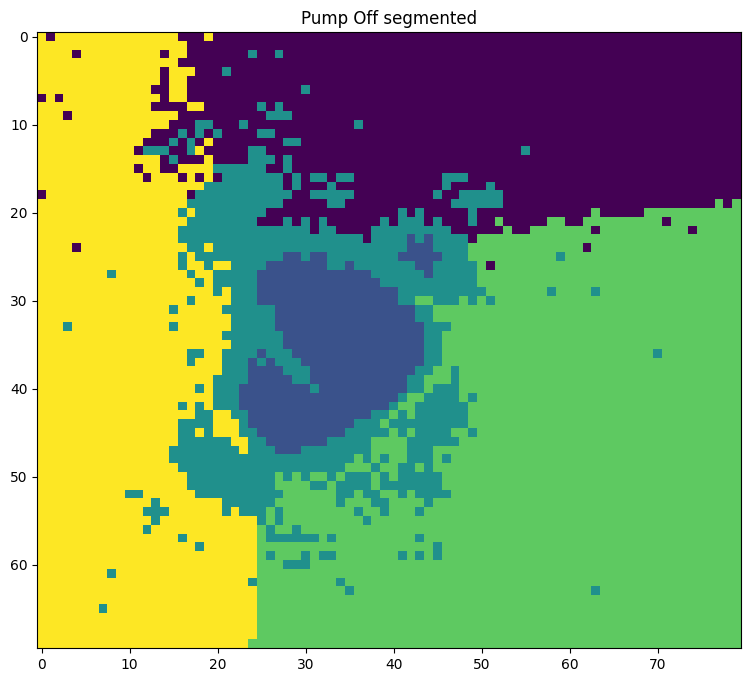

In [215]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.imshow(segmented)
ax.set_title("Pump Off segmented")

In [281]:
images = roi_poffs

x, y = np.meshgrid(np.arange(images.shape[2]), np.arange(images.shape[1]))
coordinates = np.column_stack([x.ravel(), y.ravel()])
pixel_values = image.ravel()

mask = pixel_values > 0.5
filtered_coordinates = coordinates[mask]
filtered_pixel_values = pixel_values[mask]

# 좌표와 픽셀 값을 결합한 데이터 생성 (x, y, pixel_value)
data = np.column_stack([filtered_coordinates, filtered_pixel_values])

gmm = GMM(n_components=20, covariance_type='full')
gmm.fit(data)
gmm_labels: npt.NDArray[np.int64] = gmm.predict(data)

# segmented 배열을 원본 이미지 크기로 초기화하고, 0으로 채움
segmented = np.zeros_like(pixel_values, dtype=int)
# mask에 해당하는 부분을 GMM 레이블로 채움
segmented[mask] = gmm_labels + 1 
segmented = segmented.reshape(*img.shape)
print(segmented.shape)

(70, 80)


Text(0.5, 1.0, 'Pump Off segmented')

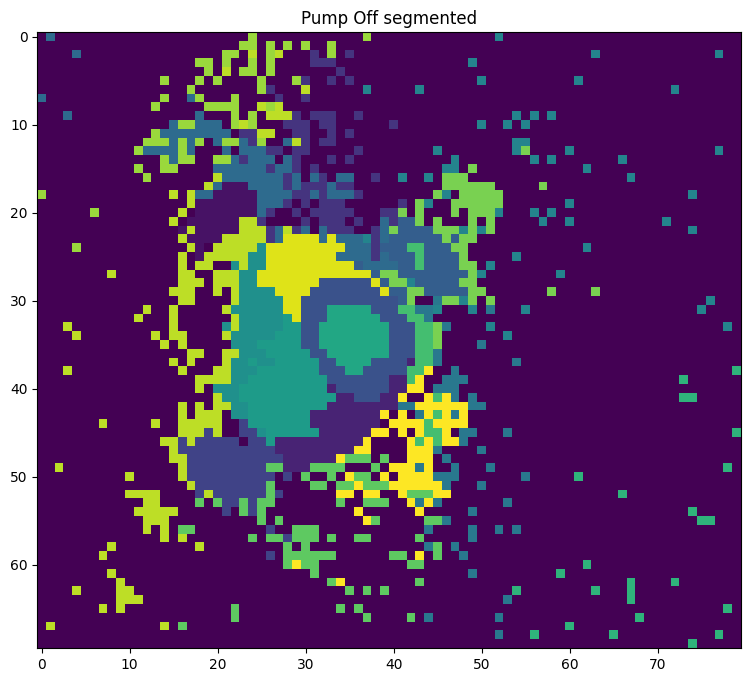

In [282]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.imshow(segmented)
ax.set_title("Pump Off segmented")

C:\Users\isaac\AppData\Local\Temp\ipykernel_22268\1537199481.py:17: RuntimeWarning: invalid value encountered in log1p
  plt.imshow(np.log1p(generated_image), cmap='viridis')


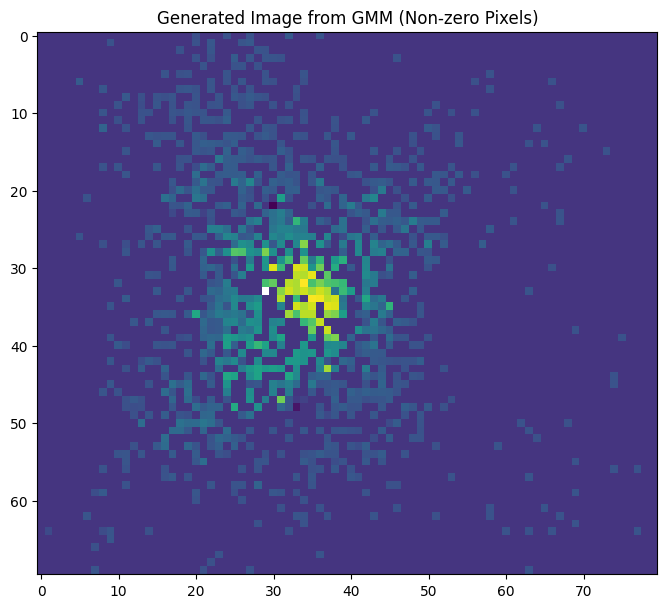

In [283]:
# GMM으로부터 새로운 데이터 생성
generated_data, _ = gmm.sample(n_samples=len(filtered_pixel_values))

# 생성된 데이터에서 좌표와 픽셀 값 분리
generated_coordinates = generated_data[:, :2].astype(int)
generated_pixel_values = generated_data[:, 2]

# 생성된 이미지를 원본과 동일한 크기로 복원
generated_image = np.zeros_like(image)
for coord, pixel_value in zip(generated_coordinates, generated_pixel_values):
    x, y = coord
    if 0 <= x < generated_image.shape[1] and 0 <= y < generated_image.shape[0]:
        generated_image[y, x] = pixel_value

# 생성된 이미지 시각화
plt.figure(figsize=(8, 8))
plt.imshow(np.log1p(generated_image), cmap='viridis')
plt.title("Generated Image from GMM (Non-zero Pixels)")
plt.show()